In [285]:
ls '../output/MNLI/mturk/'

categories1.png
cleaned_100000_fine-tuned_content-words_gold-label_beam_MNLI_labeled.csv
cleaned_100000_fine-tuned_data-slices_gold-label_beam_MNLI_labeled.csv
cleaned_100000_fine-tuned_gradient_gold-label_beam_MNLI_labeled.csv
cleaned_10000_fine-tuned_content-words_gold-label_beam_MNLI_dev_labeled.csv
cleaned_10000_fine-tuned_data-slices_gold-label_beam_MNLI_dev_labeled.csv
cleaned_10000_fine-tuned_gradient_gold-label_beam_MNLI_dev_labeled.csv
cleaned_cleaned_100000_fine-tuned_content-words_gold-label_beam_MNLI_labeled.csv
instances1.png
label-flips1.png
test.png


In [286]:
# read data
import pandas as pd
import os
from ast import literal_eval as make_tuple
from collections import Counter
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import json

random.seed(1999)


#for dev set tests
cont = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_10000_fine-tuned_content-words_gold-label_beam_MNLI_dev_labeled.csv')
sli = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_10000_fine-tuned_data-slices_gold-label_beam_MNLI_dev_labeled.csv')
grad = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_10000_fine-tuned_gradient_gold-label_beam_MNLI_dev_labeled.csv')


# for train set tests
# cont = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_content-words_gold-label_beam_MNLI_labeled.csv')
# sli = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_data-slices_gold-label_beam_MNLI_labeled.csv')
# grad = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_gradient_gold-label_beam_MNLI_labeled.csv')

#grad = grad[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]
#sli = sli[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]
#cont = cont[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]



grad.name = 'Gradient'
#sli.name = 'Data-Slice'
cont.name = 'Content'

In [337]:
t = cont.drop_duplicates('premise')
t.groupby(['flip-class']).agg({'premise': ['count']})

,premise
,count
flip-class,
Certain-Same,452
Uncertain-Flip,201
Uncertain-Same,713


### basic summary statistics: how many premises generated over, how many pairs generated

In [287]:
print(grad.shape)
print(sli.shape)
print(cont.shape)

print(len(grad['line-num'].unique()))
print(len(sli['line-num'].unique()))
print(len(cont['line-num'].unique()))

print(grad.columns)

(29991, 28)
(4917, 28)
(29991, 28)
2581
778
2581
Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'line-num',
       'pred-model', 'fill-model', 'tokens-masked', 'prepend-model',
       'sampling-strategy', 'premise', 'hypothesis', 'mask-filled',
       'token_changes', 'fill_prob', 'depth', 'Word2Vec-Score', 'Bert-Score',
       'gold-label', 'prepend-label', 'targeted-label', 'orig-label',
       'new-label', 'orig-label-prob', 'same-label-prob', 'new-label-prob',
       'label-changed', 'same-label-prob-diff', 'flip-class'],
      dtype='object')


# Obtaining good premises that make generations over all 4 classes + original

In [288]:
num_classes_thresh = 4
pairs_needed = 150
num_samples = 4

HITs_out = pd.DataFrame()
master_out = pd.DataFrame()

flip_class_counter = Counter()
mask_type_counter = Counter()

for df in (cont, grad):
    good_prems = []
    
    for k, g in df.groupby('line-num'):
        if len(g['flip-class'].unique()) >= num_classes_thresh:
            good_prems.append(k)

    print(f'{len(good_prems)} many premises that have at least {num_classes_thresh} flip classes in generations for {df.name}')
    print('\n')
    
    # sort by original label probability to get less uncertain gold labels
    good_df = df.loc[df['line-num'].isin(good_prems)].sort_values('orig-label-prob', ascending = False)
    sorted_good_prems = good_df['line-num'].unique()
    
    i = 0
    HITs_start = len(HITs_out)
    while len(HITs_out) < HITs_start + pairs_needed/(num_samples):
        # get a good premise sorted by original label probability
        prem = sorted_good_prems[i]
        i += 1
        
        # sample weighted by flip class
        gen_hypos = good_df.loc[good_df['line-num'] == prem].copy()
        gen_hypos['weights'] = np.where((gen_hypos['flip-class'] == 'Uncertain-Same') | (gen_hypos['flip-class'] == 'Uncertain-Flip'), 0.9, .1)
        gen_hypos.loc[gen_hypos['flip-class'] == 'Certain-Flip', 'weights'] = 0.2
        #hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)
        hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)

        # way to make sure that samples have ~3:1 ratio of uncertains to certains
        # and ensure that samples are somewhat diverse
        if np.sum(hit['weights']) > 2.2 and len(hit['flip-class'].unique()) > 2:
            
            # add in original prem-hypo for given premise
            orig = hit.iloc[0].copy()
            orig['tokens-masked'] = 'original'
            orig['mask-filled'] = orig['hypothesis']
            orig['flip-class'] = 'Certain-Same'
            orig['Unamed: 0.1.1'] = 0
            orig['same-label-prob'] = orig['orig-label-prob'] # original
            orig['new-label-prob'] = orig['orig-label-prob']
            orig['new-label'] = orig['orig-label']
            
            hit = hit.append(orig)
            
            # get desired rows and shuffle, so original not always at the end
            pairs = hit[['line-num', 'tokens-masked', 'Unnamed: 0.1.1', 'premise', 'mask-filled', 'orig-label-prob', 'new-label', 'flip-class']] 
            pairs = pairs.sample(frac=1, random_state = 1999)
            
            # output a line of the HIT
            HIT = pd.DataFrame()
            for j in range(num_samples + 1):
                pair = pairs.iloc[j]
                pair.index = ['premID', 'mask-type', 'hypoID', 'premise', 'hypothesis', 'orig-prob', 'model-label', 'flip-class']
                pair.index = [col_name + '_' + str(j+1) for col_name in pair.index]
                HIT = pd.concat([HIT, pair])

            # appending to total HITs
            HITs_out = HITs_out.append(HIT.T)
        
            # counting to inspect behavior and flip-label distribution
            flip_class_counter += Counter(hit['flip-class'])
            mask_type_counter += Counter(hit['tokens-masked'])
            
            # record the pairs used
            master_out = master_out.append(hit)

    print(flip_class_counter)
    print(mask_type_counter)
 

202 many premises that have at least 4 flip classes in generations for Content


Counter({'Uncertain-Same': 64, 'Certain-Same': 58, 'Uncertain-Flip': 50, 'Certain-Flip': 18})
Counter({'gradient': 152, 'original': 38})
202 many premises that have at least 4 flip classes in generations for Gradient


Counter({'Uncertain-Same': 128, 'Certain-Same': 116, 'Uncertain-Flip': 100, 'Certain-Flip': 36})
Counter({'gradient': 304, 'original': 76})


In [289]:
# HITs_out.to_csv('Pilot_Test_Batch_150-4-29-21.csv')
# master_out.to_csv('Pilot_Test_Master_150-4-29-21.csv')

In [290]:
# for dev set majority label metrics

In [291]:
def load_nli_data(path):
    """
    Load MultiNLI or SNLI data.
    """
    LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2}
    
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
            
        # really cannot change this random seed
        random.seed(1)
        random.shuffle(data)
        
    return data

# get the fraction of annotator labels that are majority
# get most common label, then divide its count by number of labels total
def get_majority_frac(row):
    maj_frac = Counter(row['annotator_labels']).most_common()[0][1]/len(row['annotator_labels'])
    return maj_frac


# identify premises that have many flip classes
# get all rows by a generation, count number of uncertains, get fraction over all generations.

def get_uncertain_frac(row):
    flip_counter = Counter(df.loc[df['line-num'] == row['line-num']]['flip-class'])

    uncertain_count = 0
    if flip_counter.get('Uncertain-Same'):
        uncertain_count += flip_counter.get('Uncertain-Same') 
    if flip_counter.get('Uncertain-Flip'):
        uncertain_count += flip_counter.get('Uncertain-Flip') 

    # number of uncertain generations over total number of generations
    uncertain_frac = uncertain_count / sum(flip_counter.values())
    
    return uncertain_frac

In [292]:
MNLI = pd.DataFrame(load_nli_data('../data/MNLI/original/multinli_1.0_dev_matched.jsonl'))
MNLI['line-num'] = MNLI.index
MNLI.shape

(9815, 13)

In [293]:
MNLI['agreement'] = MNLI.apply(lambda row : get_majority_frac(row), axis = 1)
master_out['uncertain_frac'] = master_out.apply(lambda row : get_uncertain_frac(row), axis = 1)

m_df = pd.merge(master_out, MNLI[['line-num', 'agreement']], left_on = 'line-num', right_on = 'line-num')
print(f'There are: {len(m_df["line-num"].unique())} premises generated over.')

There are: 38 premises generated over.


In [294]:
metric = m_df.groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                             count         
flip-class     agreement                   
Certain-Flip   0.6              14     38.9
               0.8               6     16.7
               1.0              16     44.4
Certain-Same   0.6              34     29.3
               0.8              30     25.9
               1.0              52     44.8
Uncertain-Flip 0.6              32     32.0
               0.8              24     24.0
               1.0              44     44.0
Uncertain-Same 0.6              40     31.2
               0.8              30     23.4
               1.0              58     45.3

In [295]:
# originals only

In [296]:
# originals only
metric = m_df.loc[m_df['tokens-masked'] == 'original'].groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                           count         
flip-class   agreement                   
Certain-Same 0.6              24     31.6
             0.8              18     23.7
             1.0              34     44.7

In [297]:
counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts = counts/sum(counts) * 100
counts

agrees = [str(t[1]) for t in metric.Fraction.index]
fracs_ratio = metric.Fraction.values

counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts_ratio = counts/sum(counts) * 100

In [298]:
# with class thresh requirement and flip class requirement, but without the weight requirement

In [299]:
num_classes_thresh = 4
pairs_needed = 150
num_samples = 4

HITs_out = pd.DataFrame()
master_out = pd.DataFrame()

flip_class_counter = Counter()
mask_type_counter = Counter()

for df in (cont, grad):
    good_prems = []
    
    for k, g in df.groupby('line-num'):
        if len(g['flip-class'].unique()) >= num_classes_thresh:
            good_prems.append(k)

    print(f'{len(good_prems)} many premises that have at least {num_classes_thresh} flip classes in generations for {df.name}')
    print('\n')
    
    # sort by original label probability to get less uncertain gold labels
    good_df = df.loc[df['line-num'].isin(good_prems)].sort_values('orig-label-prob', ascending = False)
    sorted_good_prems = good_df['line-num'].unique()
    
    i = 0
    HITs_start = len(HITs_out)
    while len(HITs_out) < HITs_start + pairs_needed/(num_samples):
        # get a good premise sorted by original label probability
        prem = sorted_good_prems[i]
        i += 1
        
        # sample weighted by flip class
        gen_hypos = good_df.loc[good_df['line-num'] == prem].copy()
        gen_hypos['weights'] = np.where((gen_hypos['flip-class'] == 'Uncertain-Same') | (gen_hypos['flip-class'] == 'Uncertain-Flip'), 0.9, .1)
        gen_hypos.loc[gen_hypos['flip-class'] == 'Certain-Flip', 'weights'] = 0.2
        #hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)
        hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)

        # way to make sure that samples have ~3:1 ratio of uncertains to certains
        # and ensure that samples are somewhat diverse
        if len(hit['flip-class'].unique()) > 2:
            
            # add in original prem-hypo for given premise
            orig = hit.iloc[0].copy()
            orig['tokens-masked'] = 'original'
            orig['mask-filled'] = orig['hypothesis']
            orig['flip-class'] = 'Certain-Same'
            orig['Unamed: 0.1.1'] = 0
            orig['same-label-prob'] = orig['orig-label-prob'] # original
            orig['new-label-prob'] = orig['orig-label-prob']
            orig['new-label'] = orig['orig-label']
            
            hit = hit.append(orig)
            
            # get desired rows and shuffle, so original not always at the end
            pairs = hit[['line-num', 'tokens-masked', 'Unnamed: 0.1.1', 'premise', 'mask-filled', 'orig-label-prob', 'new-label', 'flip-class']] 
            pairs = pairs.sample(frac=1, random_state = 1999)
            
            # output a line of the HIT
            HIT = pd.DataFrame()
            for j in range(num_samples + 1):
                pair = pairs.iloc[j]
                pair.index = ['premID', 'mask-type', 'hypoID', 'premise', 'hypothesis', 'orig-prob', 'model-label', 'flip-class']
                pair.index = [col_name + '_' + str(j+1) for col_name in pair.index]
                HIT = pd.concat([HIT, pair])

            # appending to total HITs
            HITs_out = HITs_out.append(HIT.T)
        
            # counting to inspect behavior and flip-label distribution
            flip_class_counter += Counter(hit['flip-class'])
            mask_type_counter += Counter(hit['tokens-masked'])
            
            # record the pairs used
            master_out = master_out.append(hit)

    print(flip_class_counter)
    print(mask_type_counter)
 

202 many premises that have at least 4 flip classes in generations for Content


Counter({'Certain-Same': 86, 'Uncertain-Same': 37, 'Certain-Flip': 34, 'Uncertain-Flip': 33})
Counter({'gradient': 152, 'original': 38})
202 many premises that have at least 4 flip classes in generations for Gradient


Counter({'Certain-Same': 172, 'Uncertain-Same': 74, 'Certain-Flip': 68, 'Uncertain-Flip': 66})
Counter({'gradient': 304, 'original': 76})


In [300]:
# merging in agreement at premise level

MNLI['agreement'] = MNLI.apply(lambda row : get_majority_frac(row), axis = 1)
master_out['uncertain_frac'] = master_out.apply(lambda row : get_uncertain_frac(row), axis = 1)

m_df = pd.merge(master_out, MNLI[['line-num', 'agreement']], left_on = 'line-num', right_on = 'line-num')
print(f'There are: {len(m_df["line-num"].unique())} premises generated over.')

There are: 38 premises generated over.


In [302]:
# Aggregate number of Orignal Premises selected that fall into Agreement Buckets

metric = m_df.loc[m_df['tokens-masked'] == 'original'].groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                           count         
flip-class   agreement                   
Certain-Same 0.6              10     13.2
             0.8              20     26.3
             1.0              46     60.5

In [303]:
# Counting how many flip classes are generated 

counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts = counts/sum(counts) * 100
counts

# Turning into Axis for bar plots
agrees = [str(t[1]) for t in metric.Fraction.index]
fracs_flip = metric.Fraction.values

counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts_flip = counts/sum(counts) * 100

In [304]:
# with class thresh, but no other restrictions

In [305]:
num_classes_thresh = 4
pairs_needed = 150
num_samples = 4

HITs_out = pd.DataFrame()
master_out = pd.DataFrame()

flip_class_counter = Counter()
mask_type_counter = Counter()

for df in (cont, grad):
    good_prems = []
    
    for k, g in df.groupby('line-num'):
        if len(g['flip-class'].unique()) >= num_classes_thresh:
            good_prems.append(k)

    print(f'{len(good_prems)} many premises that have at least {num_classes_thresh} flip classes in generations for {df.name}')
    print('\n')
    
    # sort by original label probability to get less uncertain gold labels
    good_df = df.loc[df['line-num'].isin(good_prems)].sort_values('orig-label-prob', ascending = False)
    sorted_good_prems = good_df['line-num'].unique()
    
    i = 0
    HITs_start = len(HITs_out)
    while len(HITs_out) < HITs_start + pairs_needed/(num_samples):
        # get a good premise sorted by original label probability
        prem = sorted_good_prems[i]
        i += 1
        
        # sample weighted by flip class
        gen_hypos = good_df.loc[good_df['line-num'] == prem].copy()
        gen_hypos['weights'] = np.where((gen_hypos['flip-class'] == 'Uncertain-Same') | (gen_hypos['flip-class'] == 'Uncertain-Flip'), 0.9, .1)
        gen_hypos.loc[gen_hypos['flip-class'] == 'Certain-Flip', 'weights'] = 0.2
        #hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)
        hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)

        # way to make sure that samples have ~3:1 ratio of uncertains to certains
        # and ensure that samples are somewhat diverse
        if len(hit['flip-class'].unique()) > 0:
            
            # add in original prem-hypo for given premise
            orig = hit.iloc[0].copy()
            orig['tokens-masked'] = 'original'
            orig['mask-filled'] = orig['hypothesis']
            orig['flip-class'] = 'Certain-Same'
            orig['Unamed: 0.1.1'] = 0
            orig['same-label-prob'] = orig['orig-label-prob'] # original
            orig['new-label-prob'] = orig['orig-label-prob']
            orig['new-label'] = orig['orig-label']
            
            hit = hit.append(orig)
            
            # get desired rows and shuffle, so original not always at the end
            pairs = hit[['line-num', 'tokens-masked', 'Unnamed: 0.1.1', 'premise', 'mask-filled', 'orig-label-prob', 'new-label', 'flip-class']] 
            pairs = pairs.sample(frac=1, random_state = 1999)
            
            # output a line of the HIT
            HIT = pd.DataFrame()
            for j in range(num_samples + 1):
                pair = pairs.iloc[j]
                pair.index = ['premID', 'mask-type', 'hypoID', 'premise', 'hypothesis', 'orig-prob', 'model-label', 'flip-class']
                pair.index = [col_name + '_' + str(j+1) for col_name in pair.index]
                HIT = pd.concat([HIT, pair])

            # appending to total HITs
            HITs_out = HITs_out.append(HIT.T)
        
            # counting to inspect behavior and flip-label distribution
            flip_class_counter += Counter(hit['flip-class'])
            mask_type_counter += Counter(hit['tokens-masked'])
            
            # record the pairs used
            master_out = master_out.append(hit)

    print(flip_class_counter)
    print(mask_type_counter)
 

202 many premises that have at least 4 flip classes in generations for Content


Counter({'Certain-Same': 76, 'Certain-Flip': 62, 'Uncertain-Flip': 26, 'Uncertain-Same': 26})
Counter({'gradient': 152, 'original': 38})
202 many premises that have at least 4 flip classes in generations for Gradient


Counter({'Certain-Same': 152, 'Certain-Flip': 124, 'Uncertain-Flip': 52, 'Uncertain-Same': 52})
Counter({'gradient': 304, 'original': 76})


In [306]:
MNLI['agreement'] = MNLI.apply(lambda row : get_majority_frac(row), axis = 1)
master_out['uncertain_frac'] = master_out.apply(lambda row : get_uncertain_frac(row), axis = 1)

m_df = pd.merge(master_out, MNLI[['line-num', 'agreement']], left_on = 'line-num', right_on = 'line-num')
print(f'There are: {len(m_df["line-num"].unique())} premises generated over.')

metric = m_df.groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

There are: 38 premises generated over.


agreement Fraction
                             count         
flip-class     agreement                   
Certain-Flip   0.6               4      3.2
               0.8              38     30.6
               1.0              82     66.1
Certain-Same   0.6              12      7.9
               0.8              44     28.9
               1.0              96     63.2
Uncertain-Flip 0.6               2      3.8
               0.8              18     34.6
               1.0              32     61.5
Uncertain-Same 0.6               2      3.8
               0.8              20     38.5
               1.0              30     57.7

In [307]:
metric = m_df.loc[m_df['tokens-masked'] == 'original'].groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                           count         
flip-class   agreement                   
Certain-Same 0.6               4      5.3
             0.8              24     31.6
             1.0              48     63.2

In [308]:
counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts = counts/sum(counts) * 100
counts

agrees = [str(t[1]) for t in metric.Fraction.index]
fracs_thresh = metric.Fraction.values

counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts_thresh = counts/sum(counts) * 100

In [309]:
# no restrictions whatsoever

In [310]:
num_classes_thresh = 0
pairs_needed = 150
num_samples = 4

HITs_out = pd.DataFrame()
master_out = pd.DataFrame()

flip_class_counter = Counter()
mask_type_counter = Counter()

for df in (cont, grad):
    good_prems = []
    
    for k, g in df.groupby('line-num'):
        if len(g['flip-class'].unique()) >= num_classes_thresh:
            good_prems.append(k)

    print(f'{len(good_prems)} many premises that have at least {num_classes_thresh} flip classes in generations for {df.name}')
    print('\n')
    
    # sort by original label probability to get less uncertain gold labels
    good_df = df.loc[df['line-num'].isin(good_prems)].sort_values('orig-label-prob', ascending = False)
    sorted_good_prems = good_df['line-num'].unique()
    
    i = 0
    HITs_start = len(HITs_out)
    while len(HITs_out) < HITs_start + pairs_needed/(num_samples):
        # get a good premise sorted by original label probability
        prem = sorted_good_prems[i]
        i += 1
        
        # sample weighted by flip class
        gen_hypos = good_df.loc[good_df['line-num'] == prem].copy()
        gen_hypos['weights'] = np.where((gen_hypos['flip-class'] == 'Uncertain-Same') | (gen_hypos['flip-class'] == 'Uncertain-Flip'), 0.9, .1)
        gen_hypos.loc[gen_hypos['flip-class'] == 'Certain-Flip', 'weights'] = 0.2
        #hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)
        hit = gen_hypos.sample(n=num_samples, weights='weights', axis = 0, random_state = 1999)

        # way to make sure that samples have ~3:1 ratio of uncertains to certains
        # and ensure that samples are somewhat diverse
        if len(hit['flip-class'].unique()) > 0:
            
            # add in original prem-hypo for given premise
            orig = hit.iloc[0].copy()
            orig['tokens-masked'] = 'original'
            orig['mask-filled'] = orig['hypothesis']
            orig['flip-class'] = 'Certain-Same'
            orig['Unamed: 0.1.1'] = 0
            orig['same-label-prob'] = orig['orig-label-prob'] # original
            orig['new-label-prob'] = orig['orig-label-prob']
            orig['new-label'] = orig['orig-label']
            
            hit = hit.append(orig)
            
            # get desired rows and shuffle, so original not always at the end
            pairs = hit[['line-num', 'tokens-masked', 'Unnamed: 0.1.1', 'premise', 'mask-filled', 'orig-label-prob', 'new-label', 'flip-class']] 
            pairs = pairs.sample(frac=1, random_state = 1999)
            
            # output a line of the HIT
            HIT = pd.DataFrame()
            for j in range(num_samples + 1):
                pair = pairs.iloc[j]
                pair.index = ['premID', 'mask-type', 'hypoID', 'premise', 'hypothesis', 'orig-prob', 'model-label', 'flip-class']
                pair.index = [col_name + '_' + str(j+1) for col_name in pair.index]
                HIT = pd.concat([HIT, pair])

            # appending to total HITs
            HITs_out = HITs_out.append(HIT.T)
        
            # counting to inspect behavior and flip-label distribution
            flip_class_counter += Counter(hit['flip-class'])
            mask_type_counter += Counter(hit['tokens-masked'])
            
            # record the pairs used
            master_out = master_out.append(hit)

    print(flip_class_counter)
    print(mask_type_counter)
 

2581 many premises that have at least 0 flip classes in generations for Content


Counter({'Certain-Same': 156, 'Certain-Flip': 15, 'Uncertain-Same': 12, 'Uncertain-Flip': 7})
Counter({'gradient': 152, 'original': 38})
2581 many premises that have at least 0 flip classes in generations for Gradient


Counter({'Certain-Same': 312, 'Certain-Flip': 30, 'Uncertain-Same': 24, 'Uncertain-Flip': 14})
Counter({'gradient': 304, 'original': 76})


In [311]:
MNLI['agreement'] = MNLI.apply(lambda row : get_majority_frac(row), axis = 1)
master_out['uncertain_frac'] = master_out.apply(lambda row : get_uncertain_frac(row), axis = 1)

m_df = pd.merge(master_out, MNLI[['line-num', 'agreement']], left_on = 'line-num', right_on = 'line-num')
print(f'There are: {len(m_df["line-num"].unique())} premises generated over.')

metric = m_df.groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

There are: 38 premises generated over.


agreement Fraction
                             count         
flip-class     agreement                   
Certain-Flip   0.6               2      6.7
               0.8               6     20.0
               1.0              22     73.3
Certain-Same   0.6              40     12.8
               0.8              40     12.8
               1.0             232     74.4
Uncertain-Flip 0.8               4     28.6
               1.0              10     71.4
Uncertain-Same 0.6               8     33.3
               1.0              16     66.7

In [312]:
metric = m_df.loc[m_df['tokens-masked'] == 'original'].groupby(['flip-class', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='flip-class').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                           count         
flip-class   agreement                   
Certain-Same 0.6              10     13.2
             0.8              10     13.2
             1.0              56     73.7

In [313]:
counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts = counts/sum(counts) * 100
counts

agrees = [str(t[1]) for t in metric.Fraction.index]
fracs_none = metric.Fraction.values

counts = m_df['flip-class'].groupby(m_df['flip-class']).size()
N = sum(counts)
counts_none = counts/sum(counts) * 100

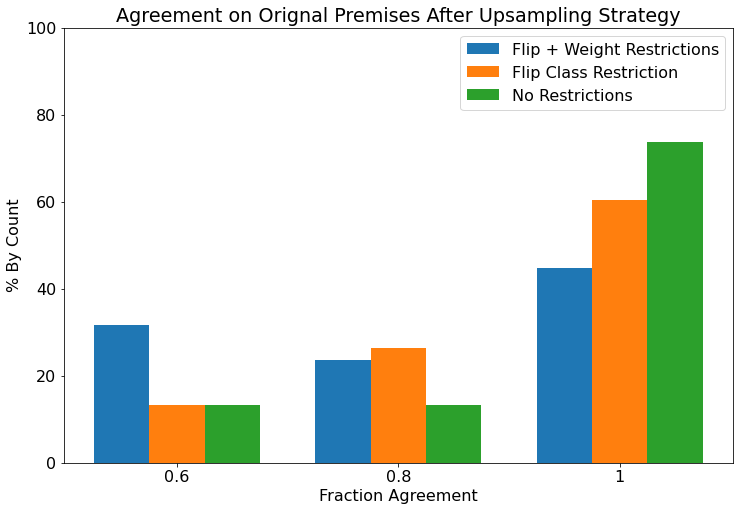

In [331]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

width = 0.25
plt.rcParams.update({'font.size': 16})

a = ax.bar(np.arange(len(fracs_ratio)), fracs_ratio, width, alpha = 1)
b = ax.bar(np.arange(len(fracs_flip))+width, fracs_flip, width, alpha = 1)
c = ax.bar(np.arange(len(fracs_none))+width+width, fracs_none, width, alpha = 1)



ax.set_ylabel('% By Count')
ax.set_title(f'Agreement on Orignal Premises After Upsampling Strategy')
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(len(fracs_none))+width)
ax.set_xticklabels( ('0.6', '0.8', '1'))
ax.set_xlabel('Fraction Agreement')
ax.legend((a[0], b[0], c[0]), ('Flip + Weight Restrictions', 'Flip Class Restriction', 'No Restrictions') )
plt.savefig('Dev Set Agreement on Orignal After Upsampling.png', dpi =200)

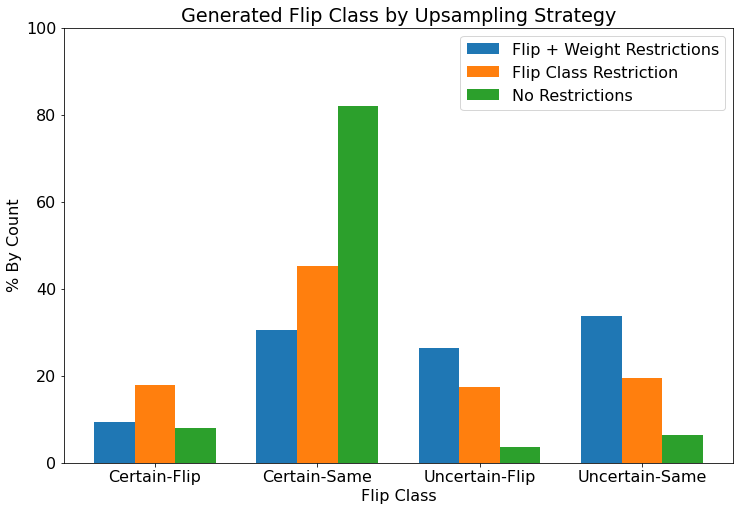

In [332]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

width = 0.25

plt.rcParams.update({'font.size': 16})

a = ax.bar(np.arange(len(counts_ratio)), counts_ratio, width, alpha = 1)
b = ax.bar(np.arange(len(counts_flip))+width, counts_flip, width, alpha = 1)
c = ax.bar(np.arange(len(counts_none))+width+width, counts_none, width, alpha = 1)

ax.set_ylabel('% By Count')
ax.set_title(f'Generated Flip Class by Upsampling Strategy')
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(len(counts_none))+width)
ax.set_xticklabels( ('Certain-Flip', 'Certain-Same', 'Uncertain-Flip', 'Uncertain-Same') )
ax.set_xlabel('Flip Class')
ax.legend((a[0], b[0], c[0]), ('Flip + Weight Restrictions', 'Flip Class Restriction', 'No Restrictions') )
plt.savefig('Dev Set Generation by Flip Class After Upsampling.png', dpi =200)